# Summary
This notebok gives some examples for how to use [GeoPandas](https://geopandas.org/en/stable/docs/user_guide.html) and the data loading utility modules in the `src` directory.

!pwd

In [2]:
!pwd


/home/jovyan/notebooks


In [3]:
import sys
sys.path.append('..')

In [4]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from src.datasets.loading import statcan, ookla

## Geopandas
To start, geopandas uses matplotlib as a plotting backend by default. It also has some basic data to load. 

In [5]:
#Geopandas is like pandas, but has a special "geometry" 
#column and special support for geometric operations with this column
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
cities = gp.read_file(gp.datasets.get_path('naturalearth_cities'))
world.head(2)


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


<AxesSubplot: >

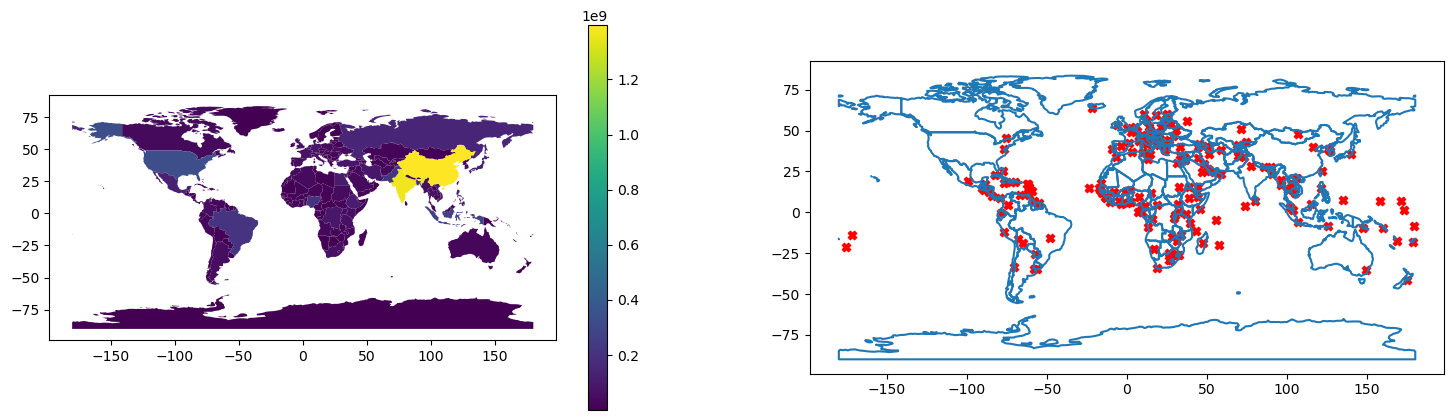

In [6]:
# Specifically the plotting is somewhat sophisticated,
# with support for chloropeth maps
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))
world.plot(column=world.pop_est, legend=True, ax=ax1)
world.boundary.plot(ax=ax2)
cities.plot(marker='X', color='red', ax=ax2)

## Basic Plotting of Tiles + Statistics Canda Shapefiles
To show some utility and make a graph where you can actually see the tiles individually, 
below is an example of some of the things you can do with GeoPandas.

In [7]:
## Statcan Data: list names of available shapefiles
statcan.boundary_names()

['provinces',
 'provinces_digital',
 'federal_electoral_districts_2013_representation_order',
 'economic_regions',
 'census_divisions',
 'population_centres',
 'population_ecumene',
 'dissemination_areas',
 'dissemination_blocks',
 'census_subdivisions',
 'designated_places',
 'lakes_and_rivers_polygons']

In [8]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [ ]:
#Use a buffer to increase Calgary size, envelope creates a bounding box for use later.
calgary_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Calgary'].copy()
calgary_area.geometry = calgary_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

In [ ]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(calgary_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

In [ ]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(calgary_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)


### Census Info
Also some census data is available on populations.

In [ ]:
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

In [ ]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)

## Calculate Statistics

In [ ]:
census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')

In [ ]:
divs_pops = statcan.census_divisions_populations()
divs_pops.DAPOP = pd.to_numeric(divs_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
divs_pops


In [ ]:
census_speeds_agg = (census_divs_speeds.groupby('CDUID')['avg_d_kbps'].mean()/1000).rename('avg_d_mpbs')

In [ ]:
statcan.boundary('census_divisions').merge(census_speeds_agg, left_on="CDUID", right_index=True).plot(column='avg_d_mpbs', legend=True)
plt.gcf().suptitle("Census Divisions Average Download Speeds (Mbps)")
plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)")